In [5]:
!pip install sacrebleu
!pip install sacremoses
import pandas as pd
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import numpy as np
from tqdm.auto import tqdm, trange
import random
from torch import nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 22.6 MB/s eta 0:00:0000:01


In [2]:
src_file = '/kaggle/input/americas-nlp/americas npl/wixarika-spanish/train.hch'
target_file = '/kaggle/input/americas-nlp/americas npl/wixarika-spanish/train.es'
tsv_data = '/kaggle/input/americas-nlp/americas npl/wixarika-spanish/extra.tsv'
parallel_data_src = None
parallel_data_target = None
target_lang = 'spa_Latn'
src_lang = 'hch' #wixarika 

In [3]:
def convert_to_list(file,parallel_data=None):
    lst = []
    if parallel_data==None:
        with open(file, 'r') as f:
            for line in f:
                lst.append(line.strip())
    else:
        with open(file, 'r') as f:
            for line in f:
                lst.append(line.strip())
        with open(file, 'r') as f:
            for line in f:
                lst.append(line.strip())
    return lst

src_list = convert_to_list(src_file)
target_list = convert_to_list(target_file)

In [6]:
df = pd.DataFrame({src_lang: src_list, target_lang: target_list})
df.head()
len(df)

8966

In [8]:
def is_valid_line(line):
    # Implement your logic to check if the line is valid
    # This could include checking for the correct number of tab-separated fields, etc.
    # Return True if the line is valid, False otherwise
    # For example, you can check if there are at least two columns separated by tabs:
    return len(line.strip().split('\t')) >= 2

def remove_error_lines(input_file, output_file):
    with open(input_file, 'r') as f_input, open(output_file, 'w') as f_output:
        for line in f_input:
            if is_valid_line(line):
                f_output.write(line)

# Usage example:
input_file = tsv_data
output_file = 'op.tsv'
remove_error_lines(input_file, output_file)


In [9]:
tsv_df = pd.read_csv(output_file, sep='\t',names=['_',target_lang,src_lang],)
tsv_df.drop(tsv_df.columns[0], axis=1, inplace=True) 
tsv_df = tsv_df[[tsv_df.columns[1], tsv_df.columns[0]]]
len(tsv_df)

2653

In [6]:
df = pd.concat([df, tsv_df])
df.head()
len(df)

11619

In [36]:
'''applying k fold in it '''
#train val split
# train_size = 0.9
# df_shuffled = df.sample(frac=1, random_state=42)
# train_rows = int(train_size * len(df_shuffled))

# df = df_shuffled[:train_rows]
# val_df = df_shuffled[train_rows:]

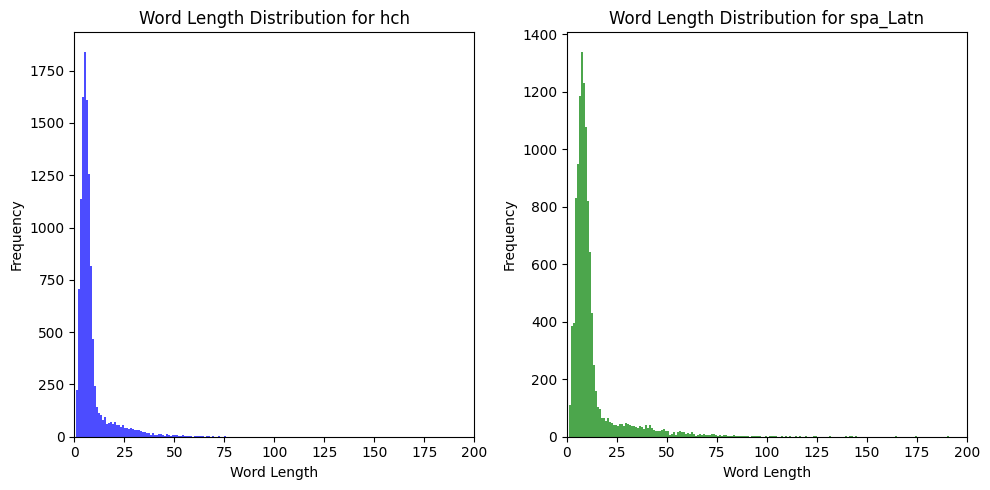

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

col1 = src_lang
col2 = target_lang


df['word_length_col1'] = df[col1].apply(lambda x: len(x.split()))
df['word_length_col2'] = df[col2].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['word_length_col1'], color='blue', alpha=0.7, bins=range(200))
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution for ' + col1)
plt.xlim(0, 200)


plt.subplot(1, 2, 2)
plt.hist(df['word_length_col2'], color='green', alpha=0.7, bins=range(200))
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution for ' + col2)
plt.xlim(0, 200) 

df.drop(['word_length_col1', 'word_length_col2'], axis=1, inplace=True)


plt.tight_layout()


plt.show()


In [9]:
from transformers import NllbTokenizer

model_name = "facebook/nllb-200-distilled-600M"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer = NllbTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
the `fairseq_tokens_to_ids` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:

if target_lang not in  tokenizer.additional_special_tokens:
    new_special_tokens = tokenizer.additional_special_tokens + [target_lang]
    tokenizer.add_special_tokens({'additional_special_tokens': new_special_tokens})
    
if src_lang not in  tokenizer.additional_special_tokens:
    new_special_tokens = tokenizer.additional_special_tokens + [src_lang]
    tokenizer.add_special_tokens({'additional_special_tokens': new_special_tokens})


In [11]:
tokenizer.src_lang = src_lang

In [12]:
tokenizer(text="cuyo dueño y señor era un ogro")

{'input_ids': [256204, 902, 252, 20026, 5990, 35, 58290, 2250, 159, 247673, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
tokenizer.src_lang = target_lang

In [14]:
tokenizer(text="cuyo dueño y señor era un ogro")

{'input_ids': [256161, 902, 252, 20026, 5990, 35, 58290, 2250, 159, 247673, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
#cheaks for number of unk in tokens

texts_with_unk = [
    text for text in tqdm(df[target_lang])
    if tokenizer.unk_token_id in tokenizer(text).input_ids
]
print(len(texts_with_unk))

  0%|          | 0/11619 [00:00<?, ?it/s]

7


In [16]:
import re
import sys
import unicodedata
from sacremoses import MosesPunctNormalizer

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " "):
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [17]:
texts_with_unk_normed = [
    text for text in tqdm(texts_with_unk) 
    if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids
]
print(len(texts_with_unk_normed))  

  0%|          | 0/7 [00:00<?, ?it/s]

0


In [19]:
import random
LANGS = [(src_lang,src_lang), (target_lang, target_lang)]
def get_batch_pairs(batch_size, data=df):
    (l1, long1), (l2, long2) = (src_lang, src_lang),(target_lang, target_lang)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))


(["kepa+ka me'enitsie xik+ri m+pa+ reku xatame,"], ['Cuando ella oyó al espejo hablar así,'], 'hch', 'spa_Latn')


In [20]:
import gc
import torch
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
def translate(
    text, src_lang=src_lang, tgt_lang=target_lang,
    a=32, b=3, max_input_length=64, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)[0]


In [71]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=k_folds)
batch_size = 16 
max_length = 64  # token sequences will be truncated
training_steps = 10000
MODEL_SAVE_PATH = '/kaggle/working/model'
k_folds = 5 

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++
bleu = []
chrf = []

for fold, (train_index, val_index) in enumerate(kf.split(df)):
    print(f"---------------fold {fold} -----------------------------")
    
    '''DEFINE MODEL AND OPTIMIZERS'''
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.cuda();
    optimizer = Adafactor(
        [p for p in model.parameters() if p.requires_grad],
        scale_parameter=False,
        relative_step=False,
        lr=1e-4,
        clip_threshold=1.0,
        weight_decay=1e-3,
        )
    scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    
    '''TRAIN AND VAL_DATA'''
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index][0:20]
    
    '''START TRAINING'''
    model.train()
    x, y, loss = None, None, None
    cleanup()
    tq = trange(0, training_steps)
    for i in tq:
        xx, yy, lang1, lang2 = get_batch_pairs(batch_size,train_df)
        try:
            tokenizer.src_lang = lang1
            x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
            tokenizer.src_lang = lang2
            y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
            # -100 is a magic value ignored in the loss function
            # because we don't want the model to learn to predict padding ids
            y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

            loss = model(**x, labels=y.input_ids).loss
            loss.backward()
            losses.append(loss.item())

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        except RuntimeError as e:  # usually, it is out-of-memory
            optimizer.zero_grad(set_to_none=True)
            x, y, loss = None, None, None
            cleanup()
            print('error', max(len(s) for s in xx + yy), e)
            continue

        if i % 1000 == 0:
            # each 1000 steps, I report average loss at these steps
            print(i, np.mean(losses[-1000:]))
    
    '''SAVE AND VALIDATION'''
    model.save_pretrained(MODEL_SAVE_PATH+str(fold))
    tokenizer.save_pretrained(MODEL_SAVE_PATH+str(fold))

    tqdm.pandas(desc="Applying function")
    val_df[target_lang + '_translated'] = val_df[src_lang].progress_apply(translate)
    val_df.to_csv(f'/kaggle/working/output{str(fold)}.csv', index=False) 
    val_df.to_excel(f'/kaggle/working/output{str(fold)}.xlsx', index=False)
    model.train()
    b = bleu_calc.corpus_score(val_df[target_lang + '_translated'].tolist(), [val_df[target_lang].tolist()])
    c = chrf_calc.corpus_score(val_df[target_lang + '_translated'].tolist(), [val_df[target_lang].tolist()])
    bleu.append(b.score)
    chrf.append(c.score)
    print(f'BLEU SCORE : '+str(b.score))
    print(f'CHRF SCORE : '+str(c.score))


In [69]:
print("avergae BLEU  ",sum(bleu) / len(bleu))
print("avergae chrf  ",sum(chrf) / len(chrf))

avergae BLEU   0.6144820827338133
avergae chrf   12.683845069484171


In [42]:
'''load_model'''
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
model_load_name = MODEL_SAVE_PATH
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
